In [ ]:
import os
import sys

sys.path.append('/Users/adamboesky/Research/ay98/Weird_Galaxies')

import pickle
from pathlib import Path
from typing import Callable, List, Optional, Union

import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from sklearn.impute import KNNImputer

In [4]:
PATH_TO_DATA = '/Volumes/T7/ay_98_data/Zou_data'
PATH_TO_TRAINING_DATA = 'Volumes/T7/ay_98_data/pickled_data'

In [8]:
def ab_mag_to_flux(AB_mag: np.ndarray) -> np.ndarray:
    """Convert AB magnitude to flux in units of mJy"""
    return 10**((AB_mag - 8.9) / -2.5) * 1000


def get_photometry_np_from_fits(filepath: Union[str, Path], columns: list, transforms: List[Union[None, Callable]], vector_key: Optional[str] = None):
    """Get given photometry fields in a numpy array from fits file path. Apply given transforms to the data. Return a vector of a column if given."""
    fits_data = np.array(fits.open(os.path.join(PATH_TO_DATA, filepath))[1].data)
    print('Importing %s', filepath)

    # # Add ids
    n = len(fits_data)
    # fits_data[vector_key] = np.arange(0, n, 1, dtype=int)  # unique id values

    # Define new dtype with additional column for unique IDs
    new_dtype = np.dtype(fits_data.dtype.descr + [(vector_key, int)])
    new_data = np.zeros(len(fits_data), dtype=new_dtype)
    for name in fits_data.dtype.names:
        new_data[name] = fits_data[name]
    new_data[vector_key] = np.arange(len(fits_data))
    fits_data = new_data



    # Drop any severely Nan columns (>50%)
    good_columns = []
    good_transforms = []
    for col, trans in zip(columns, transforms):
        num_nans = np.count_nonzero(np.isnan(fits_data[col]))
        if num_nans > 0.5 * n:
            print('Dropping column %s with %i / %i = %.2f%% NaNs', col, num_nans, n, (num_nans / n) * 100)
        else:
            print('Keeping column %s with %i / %i = %.2f%% NaNs', col, num_nans, n, (num_nans / n) * 100)
            good_columns.append(col)
            good_transforms.append(trans)
    
    # Drop severly Nan rows (>50%)
    temp_arr = np.array([fits_data[col] for col in good_columns]).T
    nan_mask = np.sum(np.isnan(temp_arr), axis=1) <= temp_arr.shape[1] / 2
    fits_data = fits_data[nan_mask]
    print('Dropped %i rows because more than half of the values were NaN', np.sum(~nan_mask))

    # Transform the data
    out_arr = np.array([fits_data[col] for col in good_columns]).T

    return out_arr

In [7]:
ALL_SURVEY_KEYS = {
    'es1': [
        'f_MIPS24',
        'f_MIPS70',
        'f_MIPS160',
        'f_PACS100',
        'f_PACS160',
        'f_SPIRE250',
        'f_SPIRE350',
        'f_SPIRE500',
        'mag_U_VOICE',
        'mag_G_DES',
        'mag_R_DES',
        'mag_I_DES',
        'mag_Z_DES',
        'mag_Y_DES',
        'mag_Z_VIDEO',
        'mag_Y_VIDEO',
        'mag_J_VIDEO',
        'mag_H_VIDEO',
        'mag_Ks_VIDEO',
        'mag_CH1',
        'mag_CH2'],
    'wcdfs': [
        'f_MIPS24',
        'f_MIPS70',
        'f_MIPS160',
        'f_PACS100',
        'f_PACS160',
        'f_SPIRE250',
        'f_SPIRE350',
        'f_SPIRE500',
        # 'mag_U_VOICE',  # over 50% nans
        # 'mag_G_VOICE',  # over 50% nans
        'mag_R_VOICE',
        # 'mag_I_VOICE',  # over 50% nans
        'mag_G_HSC',
        # 'mag_R_HSC',    # over 50% nans
        'mag_I_HSC',
        'mag_Z_HSC',
        # 'mag_Z_VIDEO',  # over 50% nans
        'mag_Y_VIDEO',
        'mag_J_VIDEO',
        'mag_H_VIDEO',
        'mag_Ks_VIDEO',
        'mag_CH1',
        'mag_CH2'
    ],
    'xmmlss': [
        'f_MIPS24',
        'f_MIPS70',
        'f_MIPS160',
        'f_PACS100',
        'f_PACS160',
        'f_SPIRE250',
        'f_SPIRE350',
        'f_SPIRE500',
        'mag_U_CFHT',
        'mag_G_HSC',
        'mag_R_HSC',
        'mag_I_HSC',
        'mag_Z_HSC',
        'mag_Y_HSC',
        'mag_Z_VIDEO',
        'mag_Y_VIDEO',
        'mag_J_VIDEO',
        'mag_H_VIDEO',
        'mag_Ks_VIDEO',
        'mag_CH1',
        'mag_CH2'
    ]
}

In [9]:
cats = []
in_transforms = [None for _ in range(8)] + [ab_mag_to_flux for _ in range(13)]
for survey in ['es1', 'wcdfs', 'xmmlss']:
    cats.append(
        get_photometry_np_from_fits(
            os.path.join(PATH_TO_DATA, f'photometry/{survey}_photcat.v1.fits'),
            ALL_SURVEY_KEYS[survey],
            transforms=in_transforms,
            vector_key='Gal_ID'
        )
    )
cats

Importing %s /Volumes/T7/ay_98_data/Zou_data/photometry/es1_photcat.v1.fits
Keeping column %s with %i / %i = %.2f%% NaNs f_MIPS24 31174 826242 3.772986606829476
Keeping column %s with %i / %i = %.2f%% NaNs f_MIPS70 81233 826242 9.831623180617784
Keeping column %s with %i / %i = %.2f%% NaNs f_MIPS160 46940 826242 5.681144265239483
Keeping column %s with %i / %i = %.2f%% NaNs f_PACS100 41906 826242 5.071879667216143
Keeping column %s with %i / %i = %.2f%% NaNs f_PACS160 41800 826242 5.0590504961016265
Keeping column %s with %i / %i = %.2f%% NaNs f_SPIRE250 0 826242 0.0
Keeping column %s with %i / %i = %.2f%% NaNs f_SPIRE350 3 826242 0.0003630897485240402
Keeping column %s with %i / %i = %.2f%% NaNs f_SPIRE500 20 826242 0.002420598323493601
Keeping column %s with %i / %i = %.2f%% NaNs mag_U_VOICE 208307 826242 25.211378748599078
Keeping column %s with %i / %i = %.2f%% NaNs mag_G_DES 79968 826242 9.678520336656815
Keeping column %s with %i / %i = %.2f%% NaNs mag_R_DES 50464 826242 6.107653

[array([[2.68632848e-01, 1.05767066e+01, 9.04286618e+01, ...,
         2.56233122e+01, 2.38144813e+01, 2.50858675e+01],
        [1.58510389e-02, 8.35253251e+00, 1.28892161e+02, ...,
         2.44108874e+01, 2.37082454e+01, 2.35384280e+01],
        [4.49594727e-01, 1.56673960e+01, 1.18284461e+02, ...,
         2.70929693e+01,            nan,            nan],
        ...,
        [2.56668121e-01, 1.10953788e+01, 9.38948674e+01, ...,
         2.03581781e+01, 2.01139074e+01, 2.03834055e+01],
        [6.86741829e-03, 7.89155099e+00, 1.19362987e+02, ...,
         2.16538941e+01, 2.17386108e+01, 2.15271196e+01],
        [2.83481231e-01, 5.27582248e+00, 5.84155325e+01, ...,
         2.43511406e+01, 2.63695762e+01,            nan]]),
 array([[2.51151566e-01, 9.70120994e+00, 7.35109622e+01, ...,
         1.94983959e+01, 1.97445965e+01, 2.00702496e+01],
        [2.32708980e-01, 3.93372923e+00, 5.39311986e+01, ...,
         1.95788002e+01, 1.76006508e+01, 1.80693817e+01],
        [9.24840317e-02, 

In [18]:
cats[0].shape

(823222, 21)

In [21]:
np.sum(np.isnan(cats[0]), axis=0) / cats[0].shape[0]

array([3.61409195e-02, 9.66458622e-02, 5.52390485e-02, 4.95650019e-02,
       4.94447427e-02, 0.00000000e+00, 2.42947832e-06, 1.70063482e-05,
       2.50241126e-01, 9.40851921e-02, 5.83026207e-02, 6.59068878e-02,
       8.58018858e-02, 2.45750235e-01, 2.72866857e-02, 3.12783186e-02,
       3.18468165e-02, 3.94182857e-02, 4.15805214e-02, 7.16538188e-02,
       1.02922419e-01])

In [30]:
grizy_props = {k: 0 for k in 'GRIZY'}
np.intersect1d([k for k in 'GRIZY'], list(grizy_props.keys()))

array(['G', 'I', 'R', 'Y', 'Z'], dtype='<U1')

In [42]:
grizy_props = {k: 0 for k in 'GRIZY'}
for i, survey in enumerate(['es1', 'wcdfs', 'xmmlss']):
    survey_keys = ALL_SURVEY_KEYS[survey]
    print(f'{survey} ({cats[i].shape[0]})')

    for k, pct in zip(survey_keys, np.sum(np.isnan(cats[i]), axis=0) / cats[i].shape[0]):
        print(f'\t{k}: {pct * 100:.2f}')

        potential_filter = np.intersect1d(k.split('_'), list(grizy_props.keys()))
        if len(potential_filter) > 0:
            grizy_props[potential_filter[0]] += np.sum(np.isnan(cats[i][:, np.where(np.array(survey_keys) == k)]), axis=0)

for k, v in grizy_props.items():
    grizy_props[k] = v / np.sum([len(cats[i]) for i in range(3)])
print(grizy_props)

es1 (823222)
	f_MIPS24: 3.61
	f_MIPS70: 9.66
	f_MIPS160: 5.52
	f_PACS100: 4.96
	f_PACS160: 4.94
	f_SPIRE250: 0.00
	f_SPIRE350: 0.00
	f_SPIRE500: 0.00
	mag_U_VOICE: 25.02
	mag_G_DES: 9.41
	mag_R_DES: 5.83
	mag_I_DES: 6.59
	mag_Z_DES: 8.58
	mag_Y_DES: 24.58
	mag_Z_VIDEO: 2.73
	mag_Y_VIDEO: 3.13
	mag_J_VIDEO: 3.18
	mag_H_VIDEO: 3.94
	mag_Ks_VIDEO: 4.16
	mag_CH1: 7.17
	mag_CH2: 10.29
wcdfs (796290)
	f_MIPS24: 1.22
	f_MIPS70: 1.29
	f_MIPS160: 1.24
	f_PACS100: 0.07
	f_PACS160: 0.07
	f_SPIRE250: 0.00
	f_SPIRE350: 0.00
	f_SPIRE500: 0.00
	mag_R_VOICE: 19.30
	mag_G_HSC: 14.96
	mag_I_HSC: 14.45
	mag_Z_HSC: 13.60
	mag_Y_VIDEO: 2.20
	mag_J_VIDEO: 1.61
	mag_H_VIDEO: 1.52
	mag_Ks_VIDEO: 1.53
	mag_CH1: 3.89
	mag_CH2: 5.07
xmmlss (1238570)
	f_MIPS24: 7.35
	f_MIPS70: 6.26
	f_MIPS160: 5.78
	f_PACS100: 0.00
	f_PACS160: 0.00
	f_SPIRE250: 0.00
	f_SPIRE350: 0.00
	f_SPIRE500: 0.00
	mag_U_CFHT: 18.06
	mag_G_HSC: 2.92
	mag_R_HSC: 2.11
	mag_I_HSC: 2.09
	mag_Z_HSC: 2.68
	mag_Y_HSC: 3.23
	mag_Z_VIDEO: 26.97
	mag_Y

In [44]:
with open('/Users/adamboesky/Research/ay98/Weird_Galaxies/Paper/final_train_history.pkl', 'rb') as file:
    train_history = pickle.load(file)

print(train_history.keys())

dict_keys(['train', 'test'])


In [47]:
len(train_history['test'])

769

In [48]:
np.min(train_history['test']), train_history['test'][-1]

(0.9212638147711316, 0.9439915261688758)

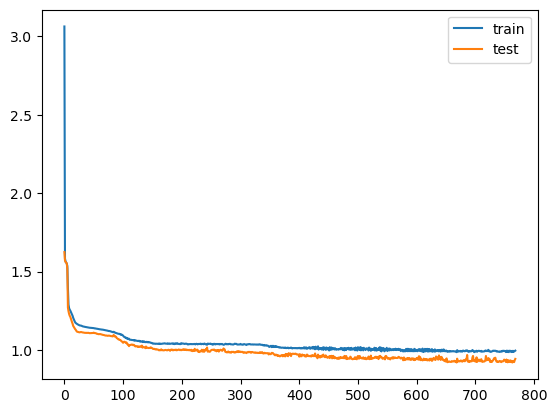

In [ ]:
plt.plot(train_history['train'], label='train')
plt.plot(train_history['test'], label='test')